In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Load Data

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_data['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

## Preprocessing

**Right now just filling missing values as a basic step of preprocessing.**

**Might change or add different preprocessing techniques once we get a base score.**

In [7]:
def visualize_missing_data(df):
    """
    This function takes a DataFrame and visualizes the number of missing data points in each column.
    """
    # Calculating the number of missing data points in each column
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]  # Filter out columns that have no missing data
    missing_data.sort_values(inplace=True)

    # Plotting
    plt.figure(figsize=(10, 6))  # Setting the figure size
    sns.barplot(x=missing_data.index, y=missing_data.values, palette='viridis')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.title('Number of Missing Data Points by Column')
    plt.xticks(rotation=45)  # Rotate labels to avoid overlap
    plt.show()


/var/folders/hm/4q0y8x6552s7hs2x2lbvrmnh0000gn/T/ipykernel_57275/1076981948.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data.values, palette='viridis')


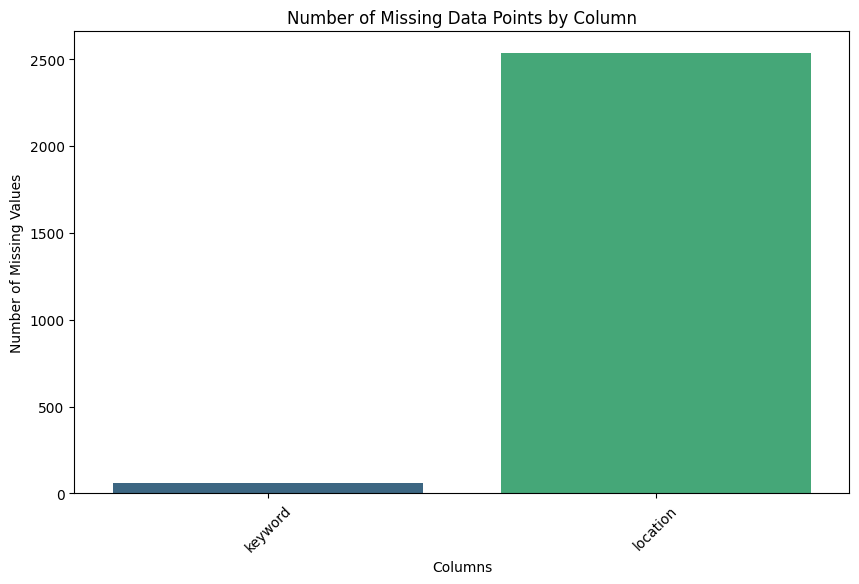

In [8]:
visualize_missing_data(train_data)

In [9]:
train_data['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [10]:
def visualize_column_value_counts(df, column, top_n=20):
    """
    This function visualizes the top N unique values and their counts for a specified column in a DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - column: str, the name of the column to analyze.
    - top_n: int, number of top unique values to display.
    """
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the DataFrame.")
    
    # Calculating value counts for the column
    value_counts = df[column].value_counts().head(top_n)
    
    # Plotting
    plt.figure(figsize=(12, 8))  # Setting the figure size
    sns.barplot(x=value_counts.values, y=value_counts.index, palette='viridis')
    plt.xlabel('Counts')
    plt.ylabel('Unique Values in ' + column)
    plt.title(f'Top {top_n} Unique Values in {column}')
    plt.show()

/var/folders/hm/4q0y8x6552s7hs2x2lbvrmnh0000gn/T/ipykernel_57275/3216225767.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='viridis')


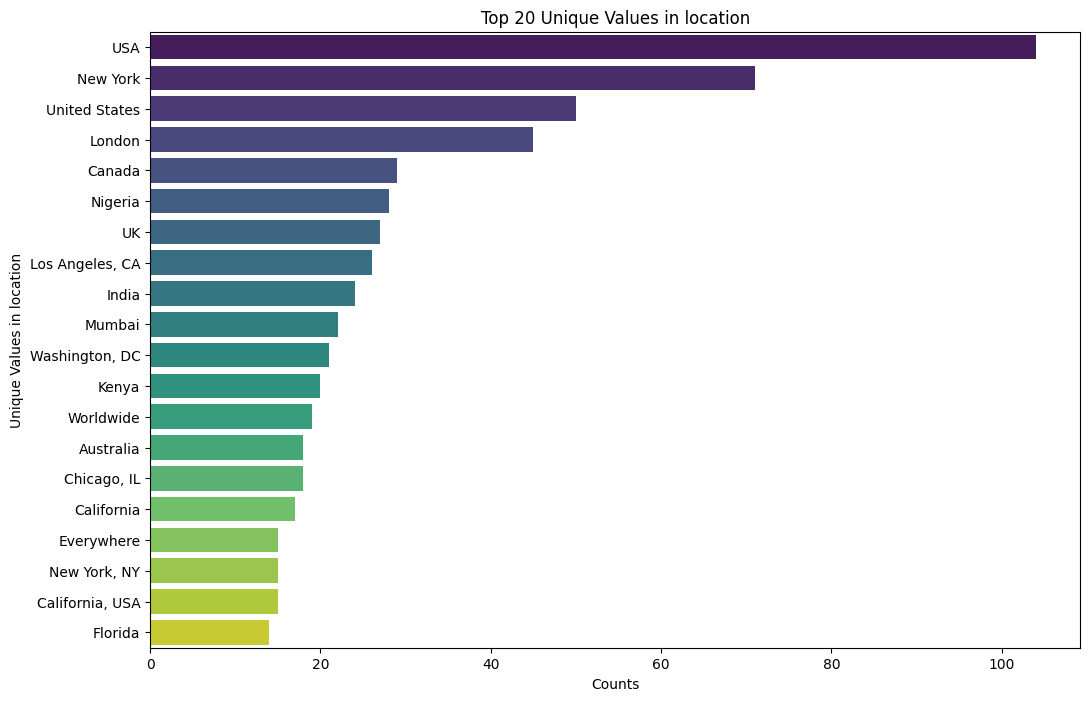

In [11]:
visualize_column_value_counts(train_data, 'location', top_n=20)

In [12]:
train_data['location'].isna().sum()

2533

With this huge difference between count of unique values and unknown datapoints for `location` it is better drop this column.

/var/folders/hm/4q0y8x6552s7hs2x2lbvrmnh0000gn/T/ipykernel_57275/3216225767.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='viridis')


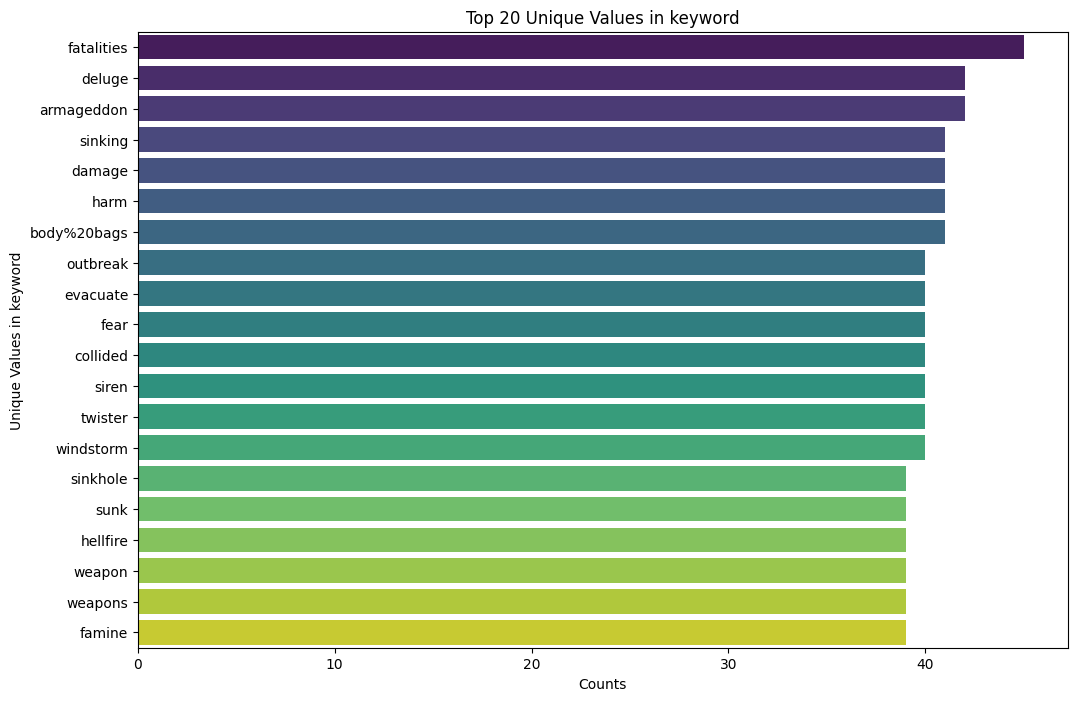

In [13]:
visualize_column_value_counts(train_data, 'keyword', top_n=20)

In [14]:
train_data['keyword'].isna().sum()

61

In [15]:
test_data['keyword'].isna().sum()

26

Only `61` rows have missing value in column `keyword`. I will just add `unsure` as the datavalue for these datapoints.

In [16]:
# # Drop rows where the 'keyword' column is NaN
# train_data = train_data.dropna(subset=['keyword'])


# # Check the number of missing values in the 'keyword' column after dropping
# print("Number of missing values in column 'keyword' after dropping rows:", train_data['keyword'].isnull().sum())
# print("Number of missing values in column 'keyword' after dropping rows:", train_data['keyword'].isnull().sum())


In [17]:
train_data['keyword'].fillna('unsure', inplace=True)
train_data['keyword'].isna().sum()

0

In [18]:
test_data['keyword'].fillna('unsure', inplace=True)
test_data['keyword'].isna().sum()

0

In [19]:
train_data = train_data.drop(['location'], axis=1)
test_data = test_data.drop(['location'], axis=1)

In [20]:
train_data.head()

,id,keyword,text,target
0,1,unsure,Our Deeds are the Reason of this #earthquake M...,1
1,4,unsure,Forest fire near La Ronge Sask. Canada,1
2,5,unsure,All residents asked to 'shelter in place' are ...,1
3,6,unsure,"13,000 people receive #wildfires evacuation or...",1
4,7,unsure,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
# train_data.fillna('', inplace=True)
# test_data.fillna('', inplace=True)


In [22]:
train_data.head(20)

,id,keyword,text,target
0,1,unsure,Our Deeds are the Reason of this #earthquake M...,1
1,4,unsure,Forest fire near La Ronge Sask. Canada,1
2,5,unsure,All residents asked to 'shelter in place' are ...,1
3,6,unsure,"13,000 people receive #wildfires evacuation or...",1
4,7,unsure,Just got sent this photo from Ruby #Alaska as ...,1
5,8,unsure,#RockyFire Update => California Hwy. 20 closed...,1
6,10,unsure,#flood #disaster Heavy rain causes flash flood...,1
7,13,unsure,I'm on top of the hill and I can see a fire in...,1
8,14,unsure,There's an emergency evacuation happening now ...,1
9,15,unsure,I'm afraid that the tornado is coming to our a...,1


**Lets try different things**

In [23]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atharvagurav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atharvagurav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

In [25]:
# Function to clean the text
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize into words
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)  # Join words back to a single string


In [26]:
# Apply normalization to text columns
train_data['text'] = train_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)


### Lexicon Normalization

In [27]:
# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stemmer and lemmatizer
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to apply stemming and lemmatization
def apply_normalization(text):
    # Tokenize text
    tokens = word_tokenize(text)
   
    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back to string
    return ' '.join(lemmatized_tokens)



# Normalize text in the 'text' column
train_data['text'] = train_data['text'].apply(lambda x: apply_normalization(x) if not pd.isnull(x) else x)
test_data['text'] = test_data['text'].apply(lambda x: apply_normalization(x) if not pd.isnull(x) else x)

print("Lexicon normalization complete and data saved.")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atharvagurav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/atharvagurav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/atharvagurav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Lexicon normalization complete and data saved.


In [28]:
# save the processed datasets back to csv files
train_data.to_csv('train_normalized_5.csv', index=False)
test_data.to_csv('test_normalized_5.csv', index=False)

## Feature Engineering
### Using CountVectorizer to convert text data to numerical data

In [29]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['text'])
y_train = train_data['target']
X_test = vectorizer.transform(test_data['text'])


## Model Training

Let's split the train data into train and validation first

In [30]:
X = X_train
y = y_train

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12,shuffle=True)


**Let's try different models and parameters.**

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Define models and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Support Vector Machine': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    }
}

# Perform Grid Search for each model
best_models = {}
for model_name, model_info in models.items():
    clf = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    best_models[model_name] = clf.best_estimator_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

# Evaluate models
for model_name, model in best_models.items():
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} F1 Score: {f1}")

# Select the best model based on F1 Score
best_model_name = max(best_models, key=lambda name: f1_score(y_val, best_models[name].predict(X_val)))
print(f"Best model: {best_model_name}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best parameters for Support Vector Machine: {'C': 0.1, 'kernel': 'linear'}
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best parameters for Naive Bayes: {'alpha': 1}
Logistic Regression Accuracy: 0.7918581746552856
Logistic Regression F1 Score: 0.7338371116708649
Support Vector Machine Accuracy: 0.8017071569271176
Support Vector Machine F1 Score: 0.7392055267702936
Random Forest Accuracy: 0.7767564018384767
Random Forest F1 Score: 0.7007042253521126
Gradient Boosting Accuracy: 0.778069599474721
Gradient Boosting F1 Score: 0.7076124567474049
Naive Bayes Accuracy: 0.7918581746552856
Naive Bayes F1 Score: 0.7395234182415776
Best model: Naive Bayes


In [32]:
# models = {
#     'Support Vector Machine': {
#         'model': SVC(),
#         'params': {
#             'C': [0.1, 1, 10],
#             'kernel': ['linear', 'rbf','poly', 'sigmoid'],
#             'gamma': ['scale', 'auto'],
#             'class_weight': [None, 'balanced']
#         }
#     },
# }

# # Perform Grid Search for each model
# best_models = {}
# for model_name, model_info in models.items():
#     clf = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy')
#     clf.fit(X_train, y_train)
#     best_models[model_name] = clf.best_estimator_
#     print(f"Best parameters for {model_name}: {clf.best_params_}")

# # Evaluate models
# for model_name, model in best_models.items():
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     print(f"{model_name} Accuracy: {accuracy}")
#     print(f"{model_name} F1 Score: {f1}")

# # Select the best model based on F1 Score
# best_model_name = max(best_models, key=lambda name: f1_score(y_val, best_models[name].predict(X_val)))
# print(f"Best model: {best_model_name}")

In [33]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

## Prediction

In [34]:
predictions = model.predict(X_test)


In [35]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

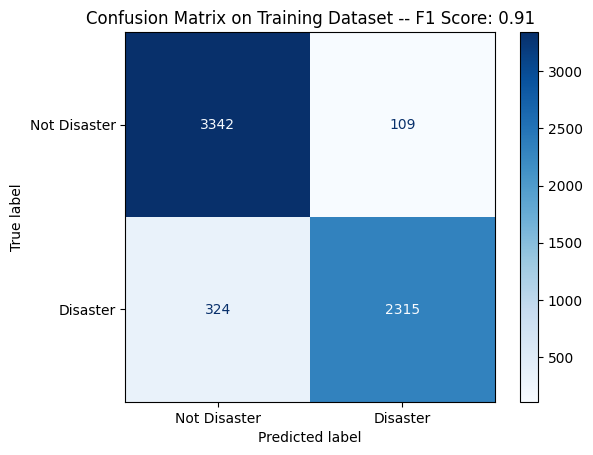

In [36]:
y_pred_train = model.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train, "Training")


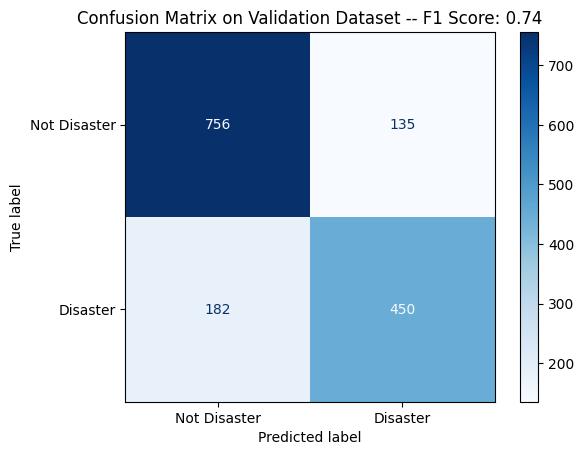

In [37]:
y_pred_val = model.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")


This huge difference in F1 score validates our previous disscusion of modeling getting overtrained.

## Let's try LSTM

In [110]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout


In [98]:

# # Initialize tokenizer
# tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
# tokenizer.fit_on_texts(train_data['text'])

# # Convert texts to sequences of integers
# sequences = tokenizer.texts_to_sequences(train_data['text'])

# # Pad sequences to ensure uniform input size
# max_seq_length = max(len(x) for x in sequences)
# X = pad_sequences(sequences, maxlen=max_seq_length)
# y = train_data['target'].values

In [99]:


# # Define the model architecture
# lstm_model = Sequential([
#     Embedding(input_dim=5000, output_dim=128, input_length=max_seq_length),
#     SpatialDropout1D(0.3),
#     LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
#     LSTM(64, dropout=0.2, recurrent_dropout=0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# lstm_model.summary()


In [100]:
# # Train the model
# history = lstm_model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)


In [101]:
# # Assuming test_data is already loaded and preprocessed
# test_sequences = tokenizer.texts_to_sequences(test_data['text'])
# X_test = pad_sequences(test_sequences, maxlen=max_seq_length)

# # Predict and evaluate the model
# predictions = lstm_model.predict(X_test)
# # Convert predictions to binary output for comparison if needed



In [102]:
# predictions

In [103]:
# binary_predictions = (predictions > 0.5).astype(int)
# binary_predictions

In [104]:
# preds = lstm_model.predict(X_val)
# y_pred_val = (preds > 0.5).astype(int)
# displayConfusionMatrix(y_val, y_pred_val, "Validation")


## Submission CSV

In [38]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions
})


In [39]:
submission.to_csv('submission8.csv', index=False)